In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Define paths
data_dir = "/content/gdrive/MyDrive/123/data"
phq9_path = "/content/gdrive/MyDrive/ABC/groundtruth/phq9.csv"
output_csv_path = "/content/gdrive/MyDrive/ABC/matched_features.csv"  # Output file

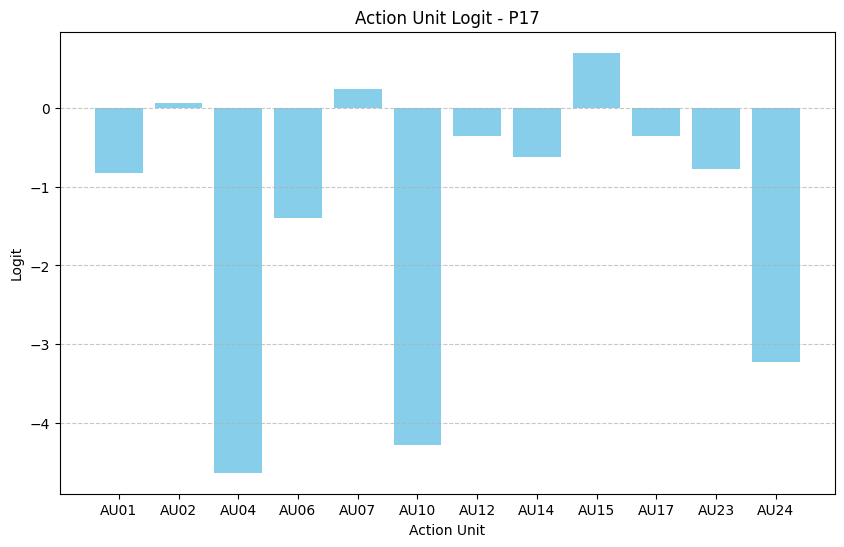

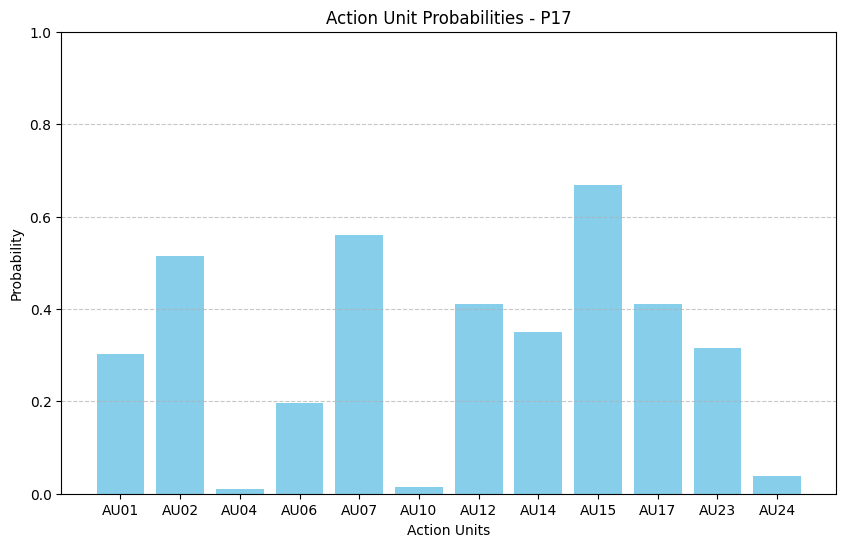

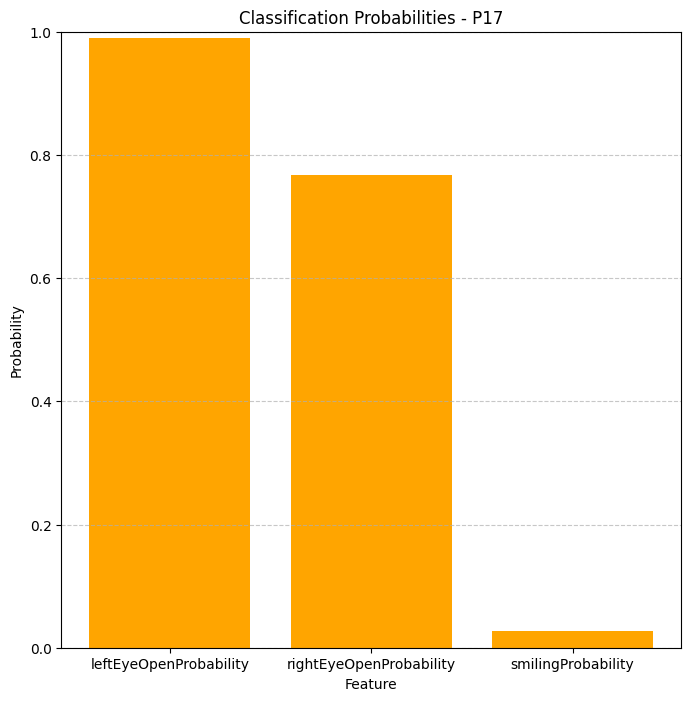

Bounding Box for P17: 131 1134 943 1963


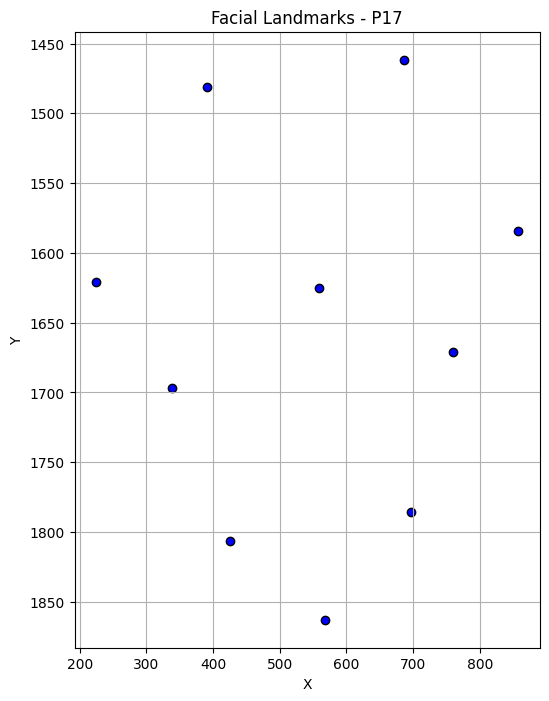

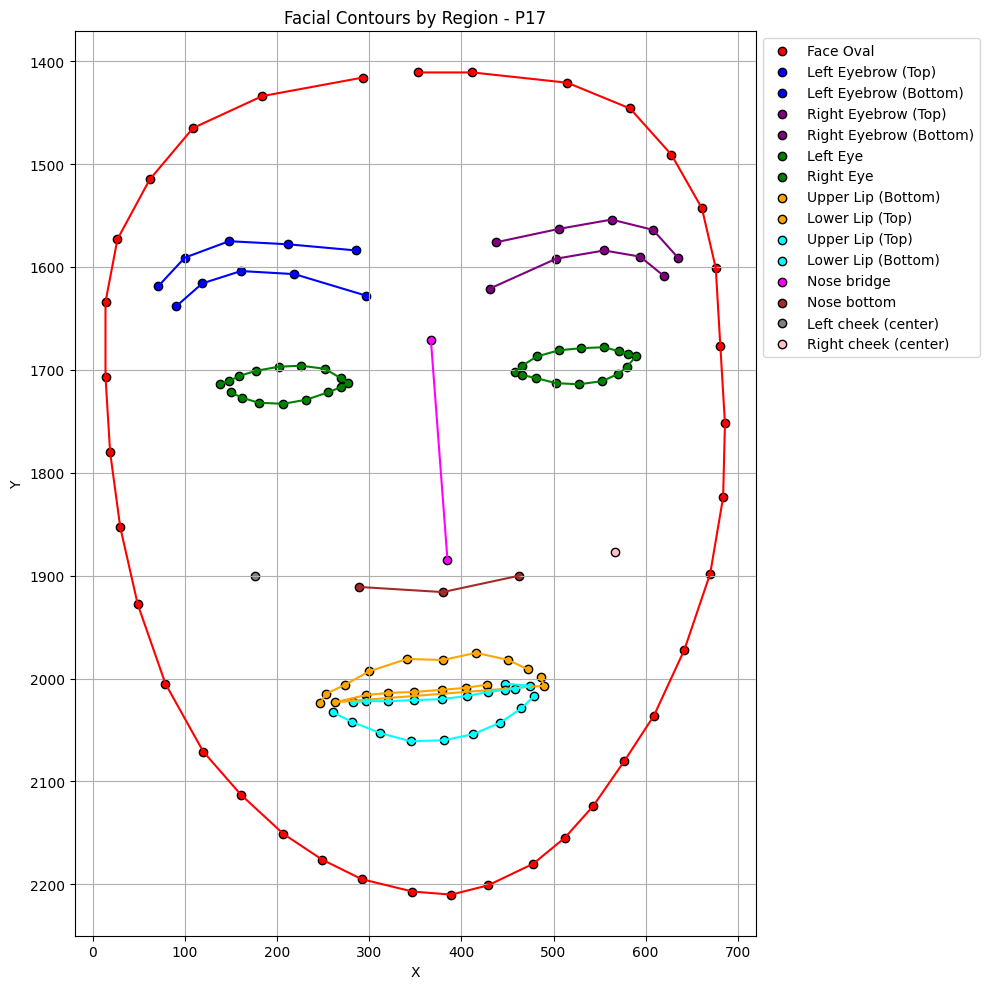

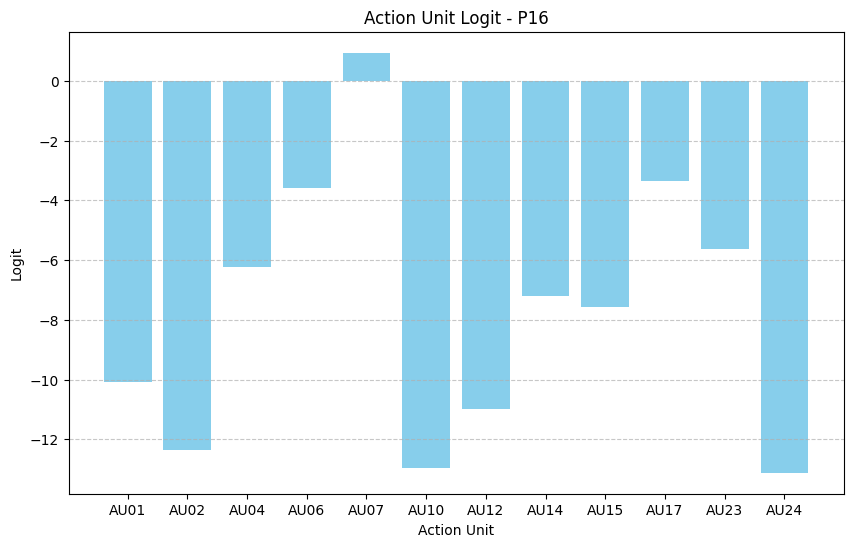

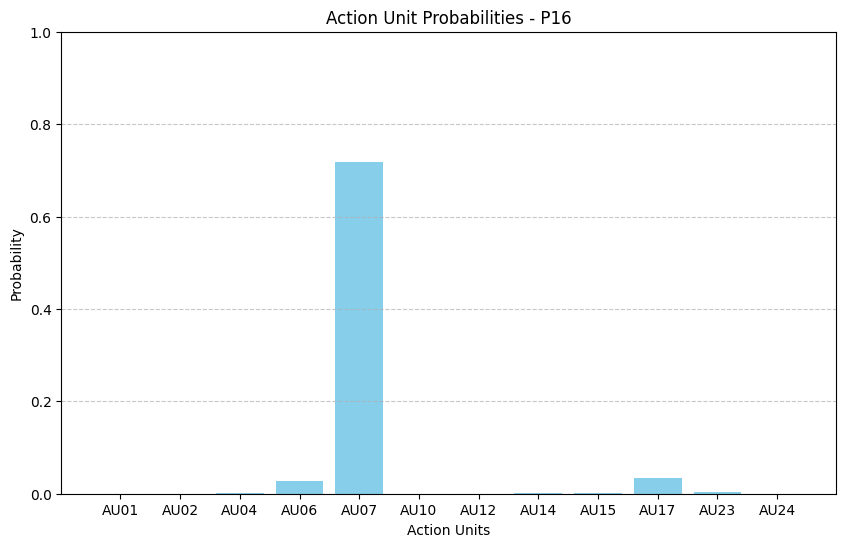

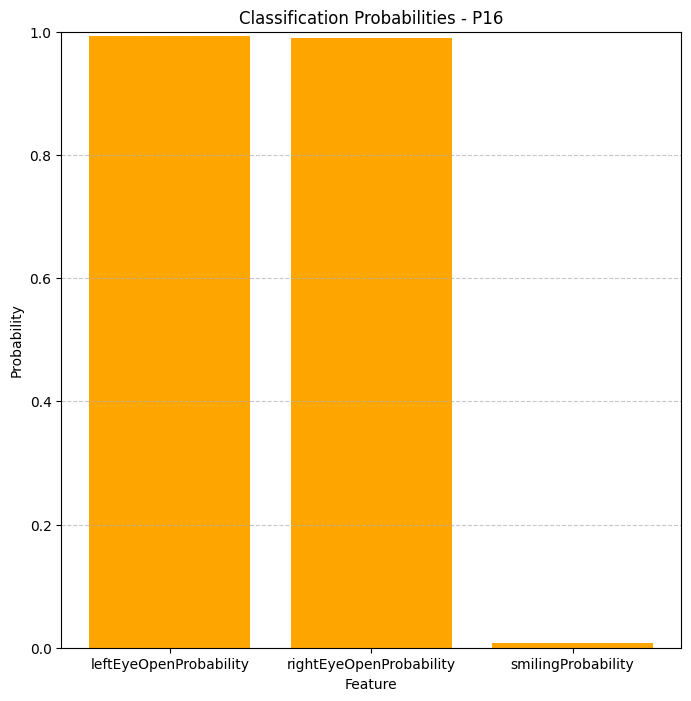

Bounding Box for P16: 189 711 984 1523


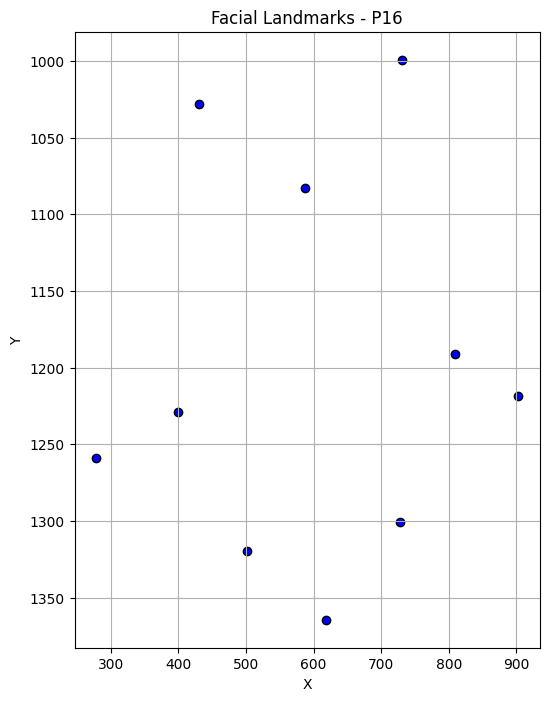

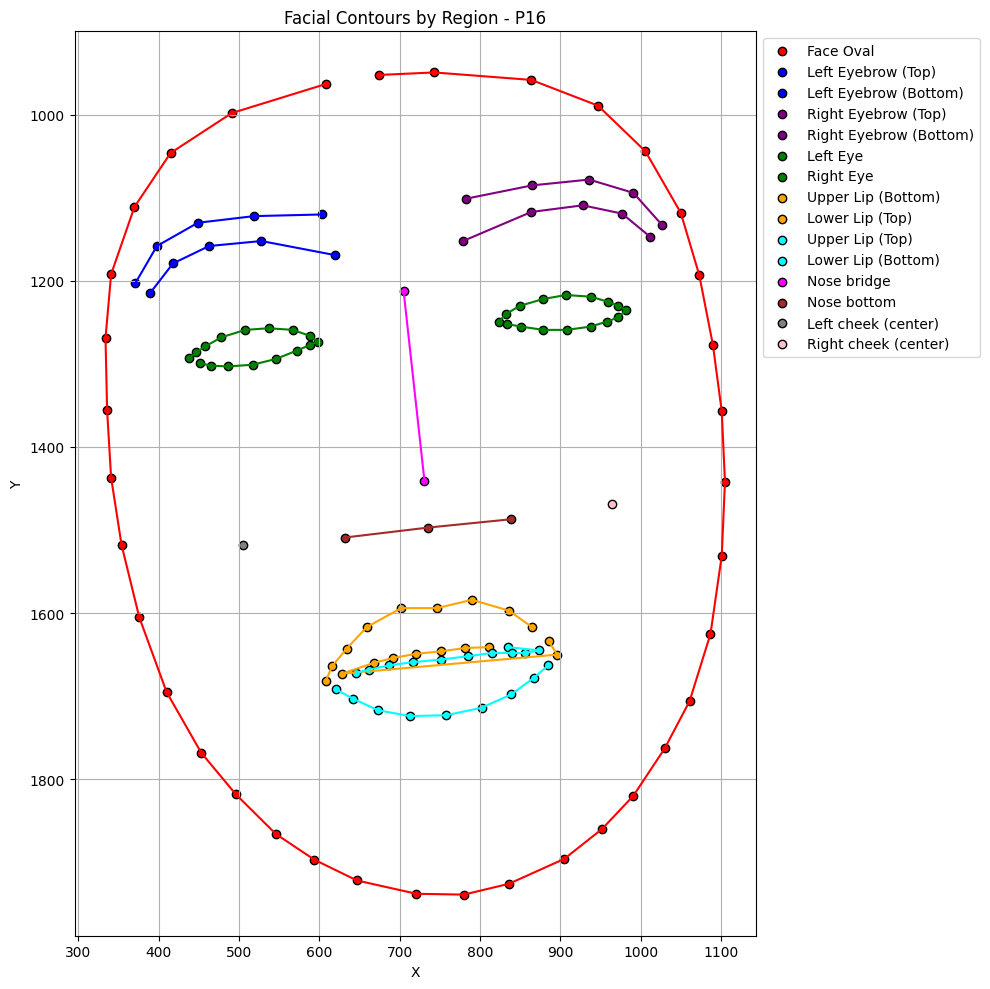

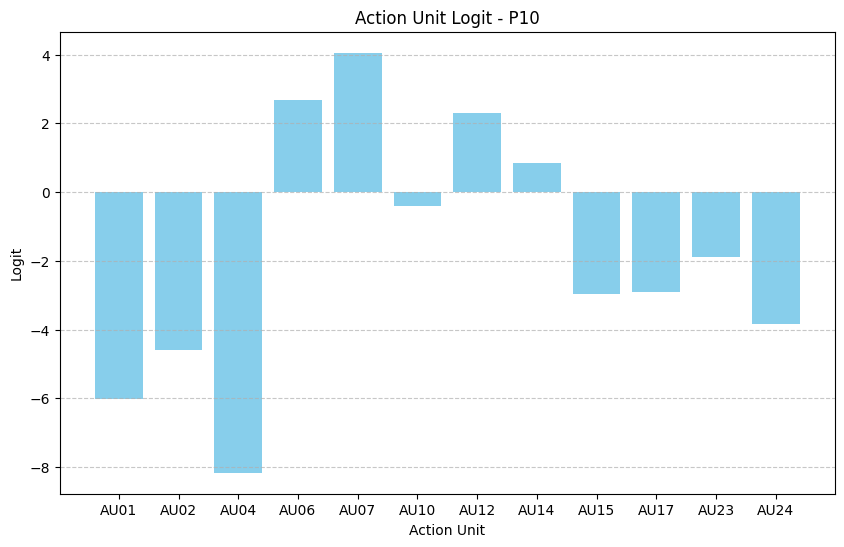

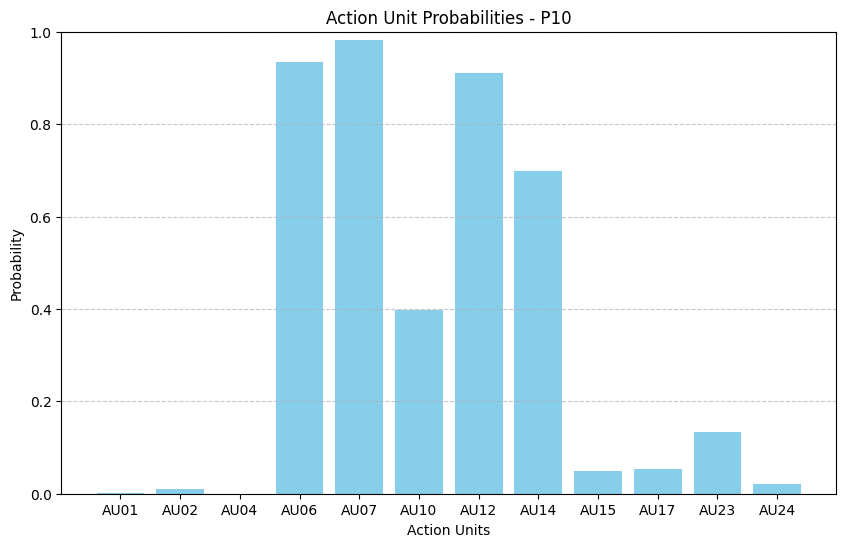

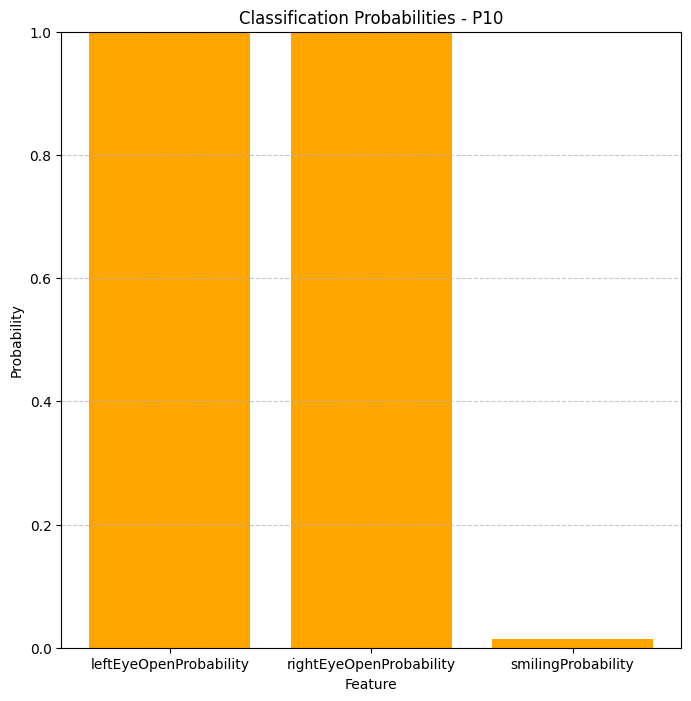

Bounding Box for P10: 88 1236 922 2069


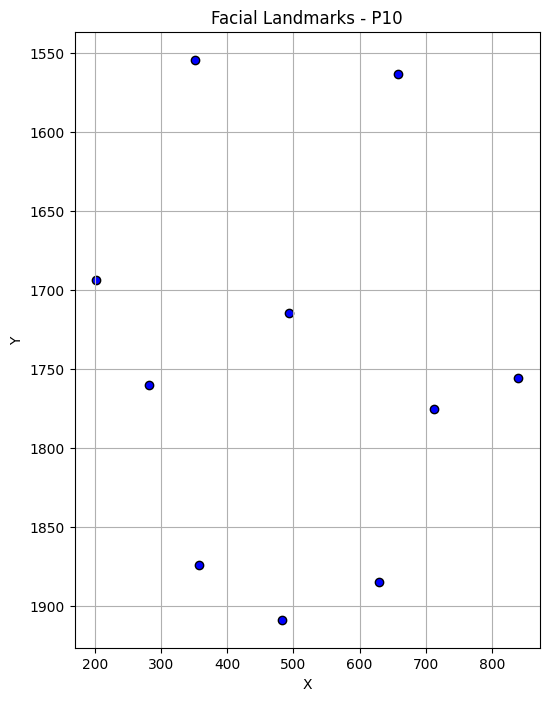

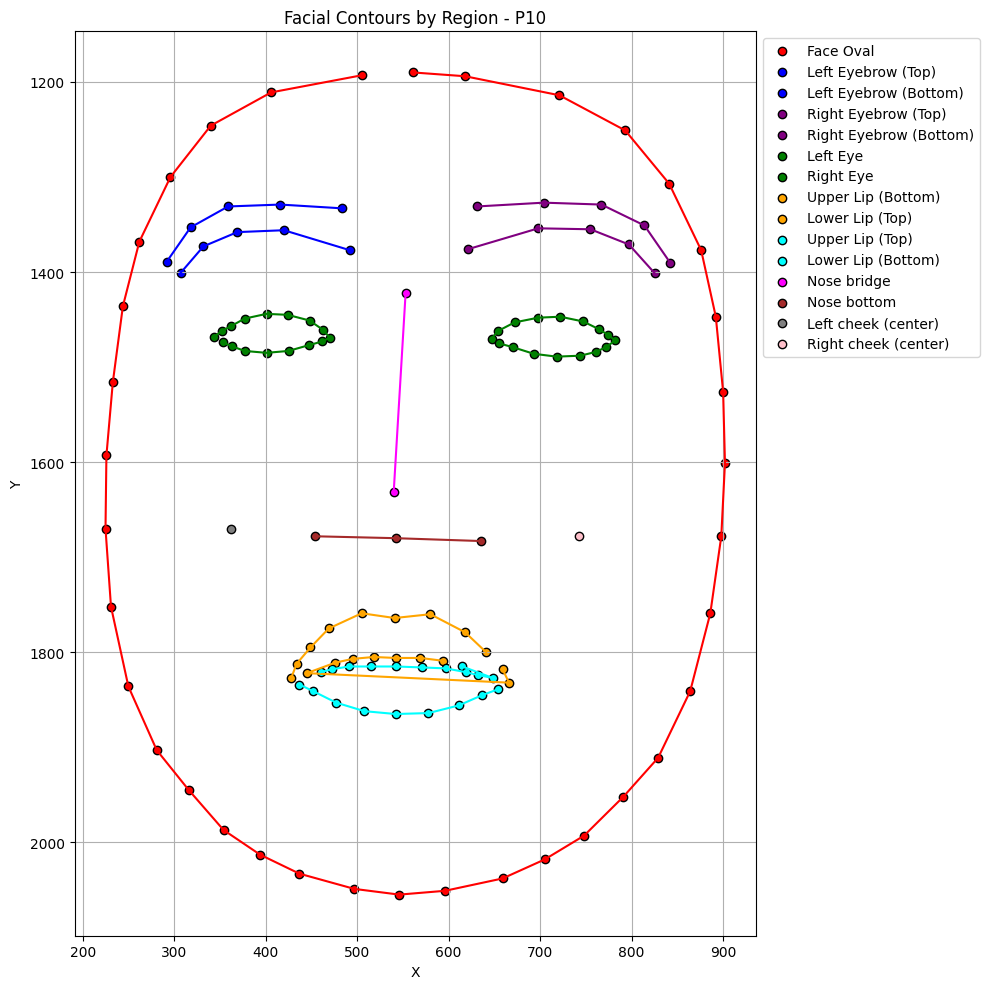

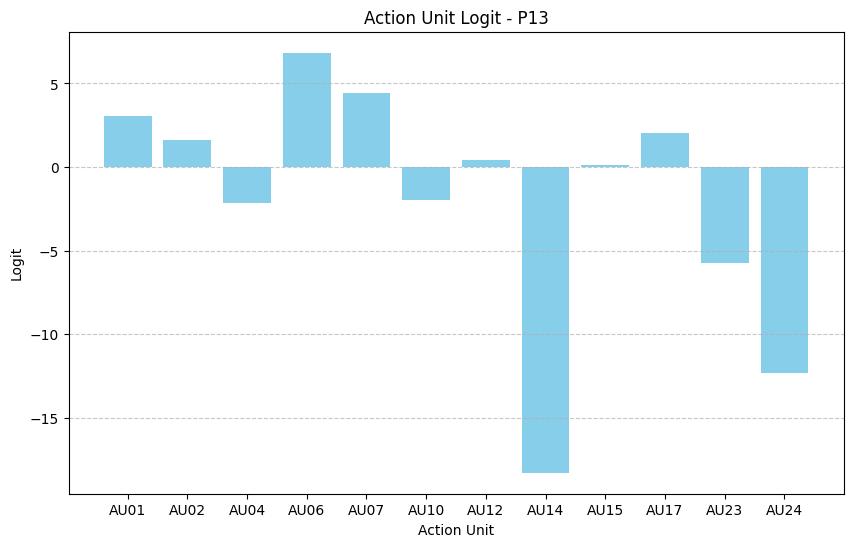

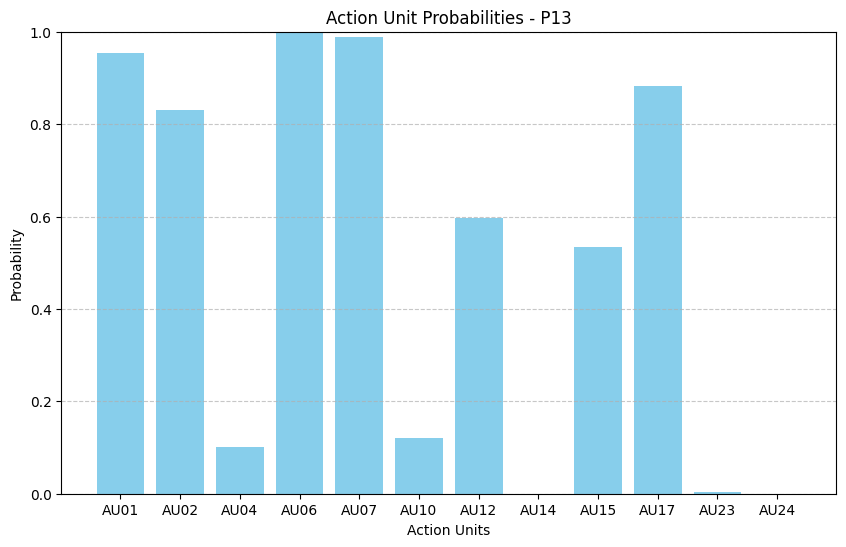

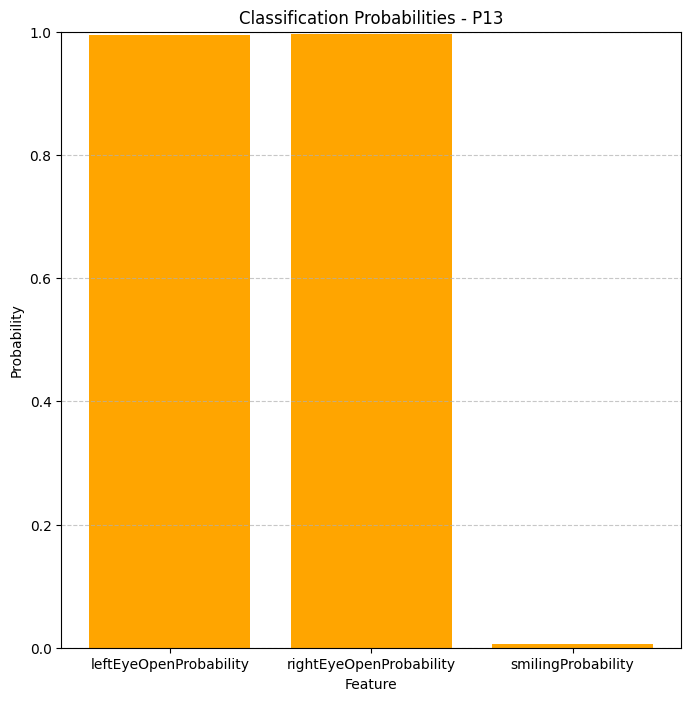

Bounding Box for P13: 377 780 1206 1610


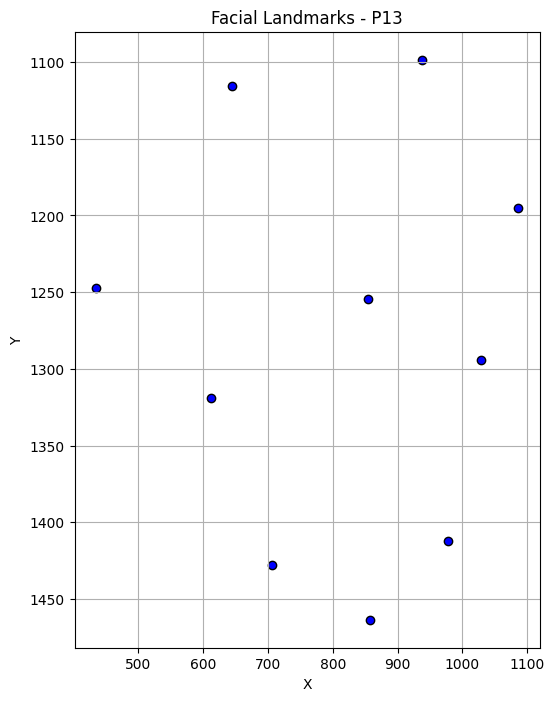

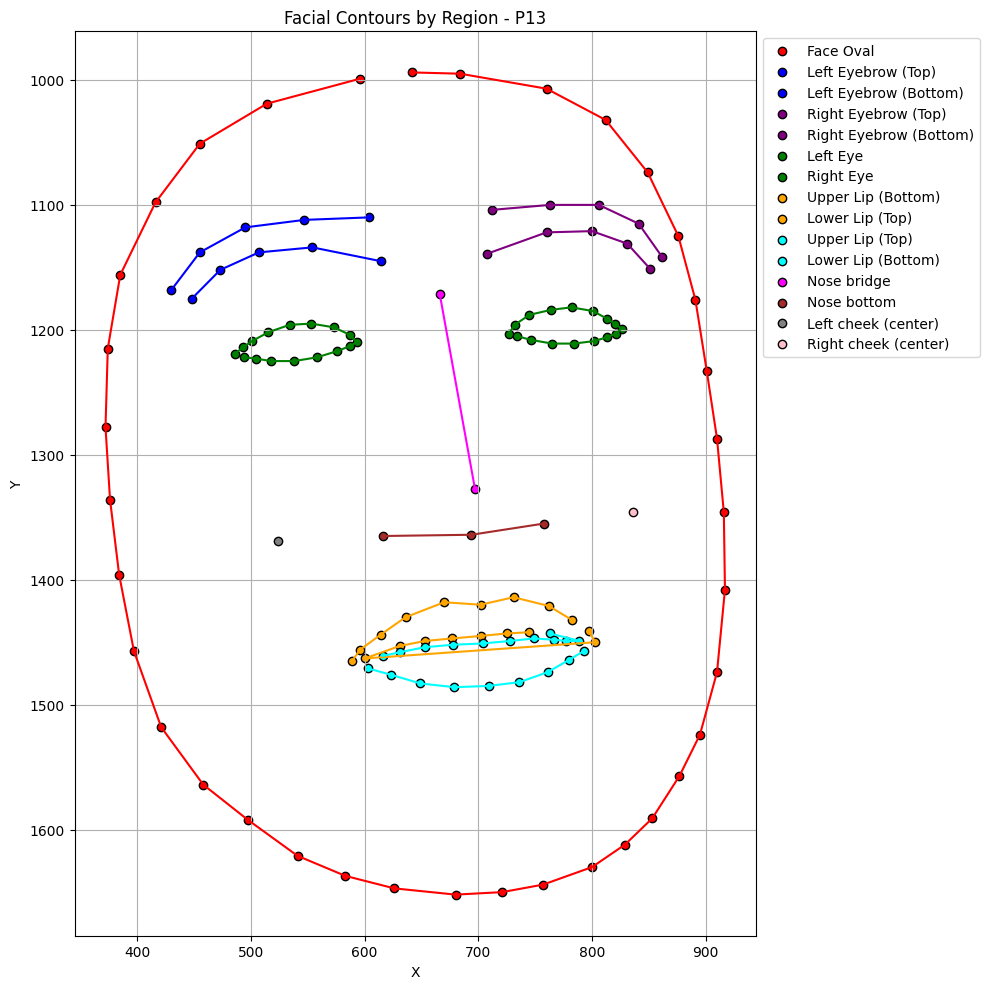

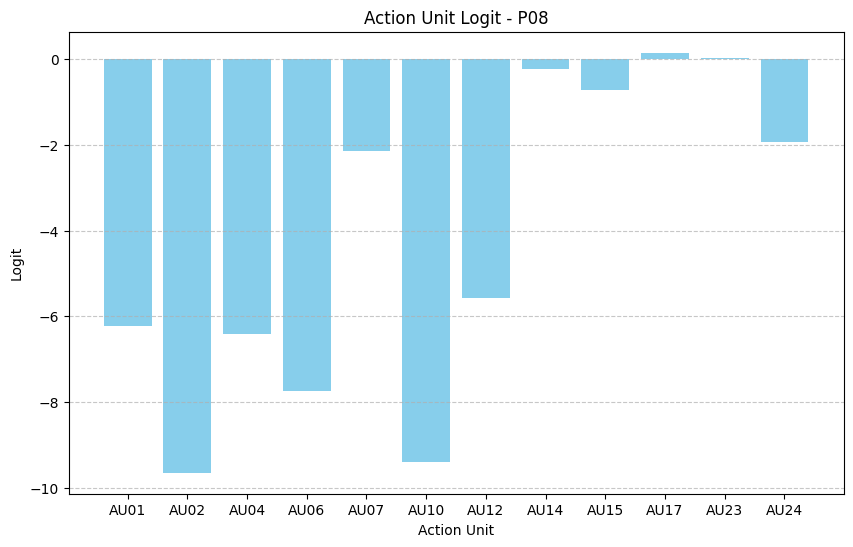

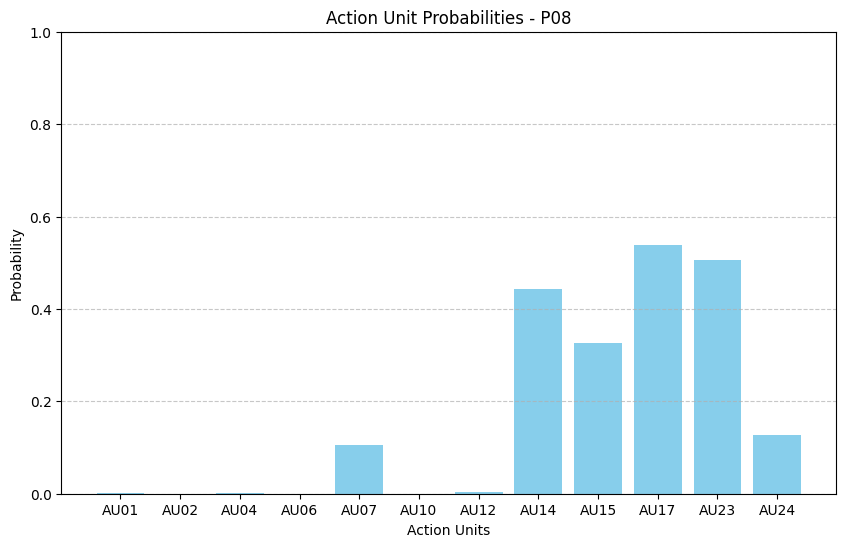

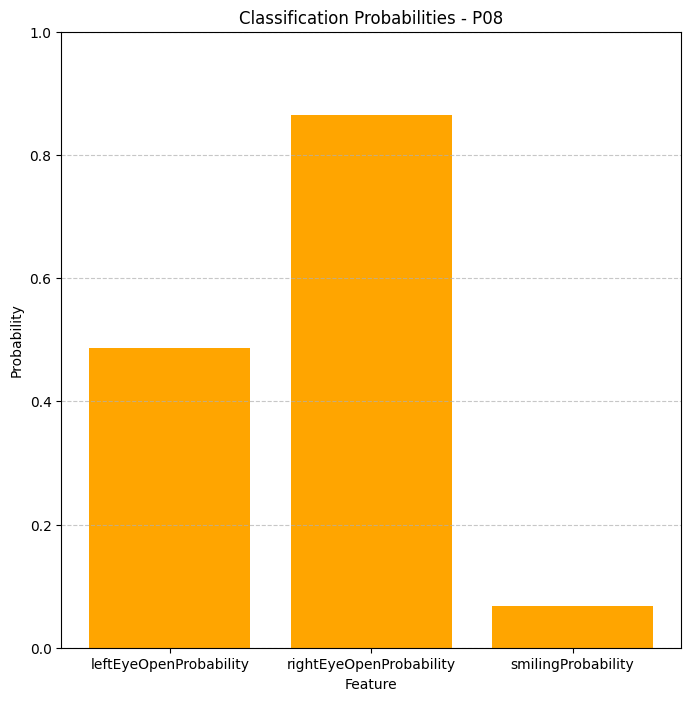

Bounding Box for P08: 285 992 1016 1723


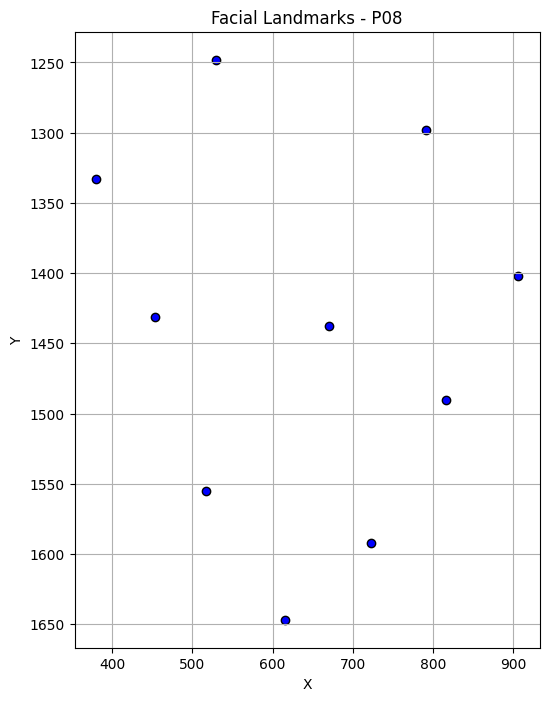

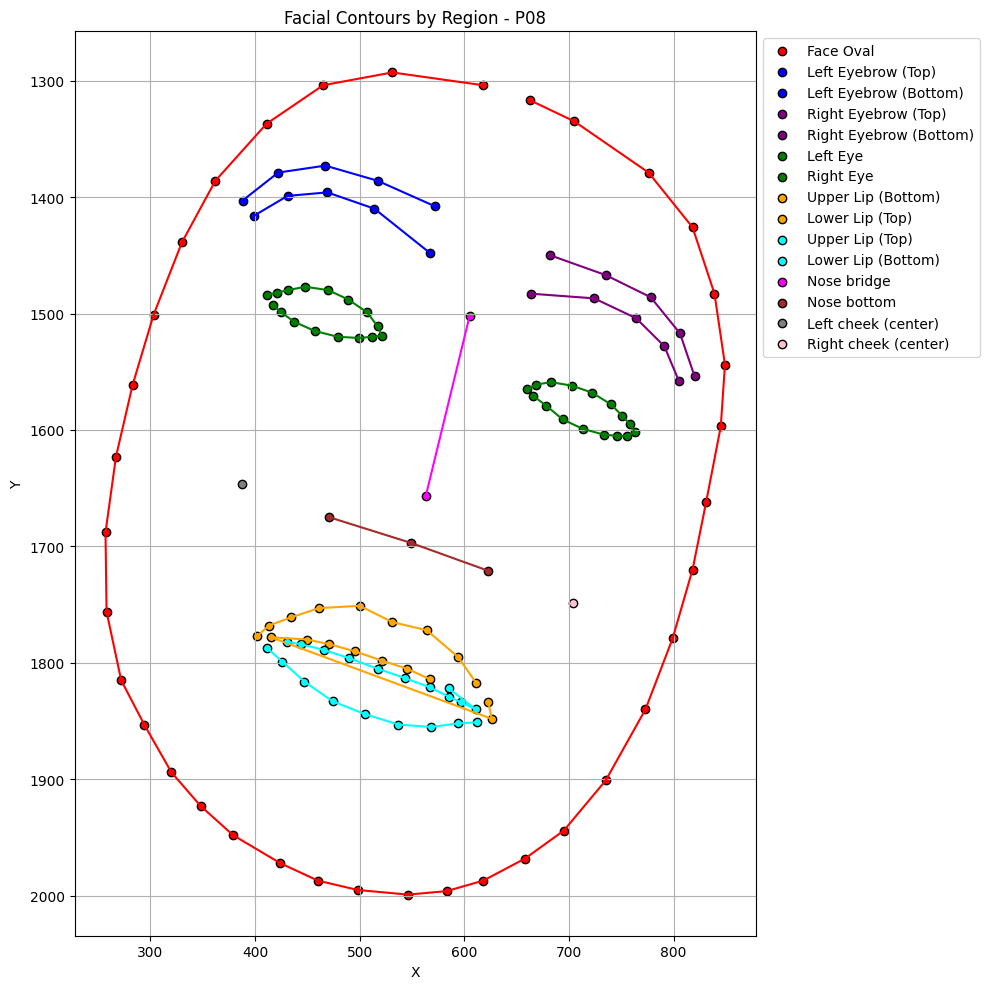

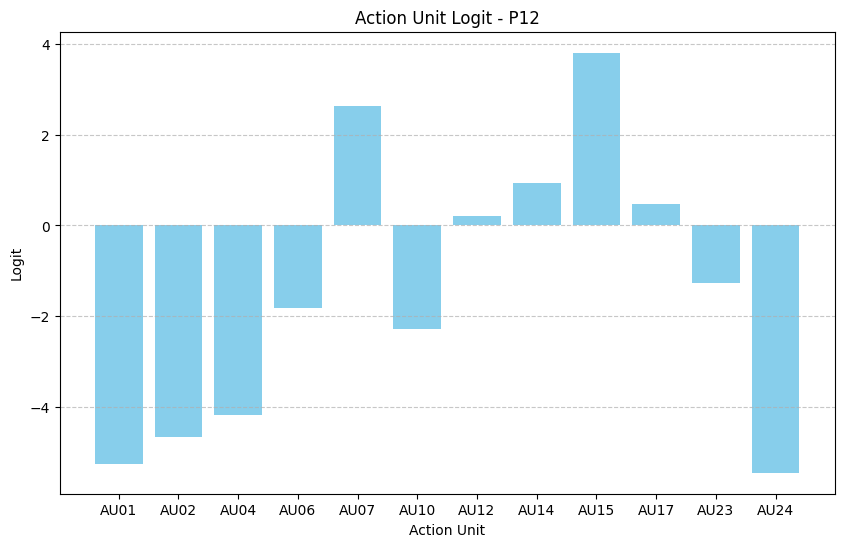

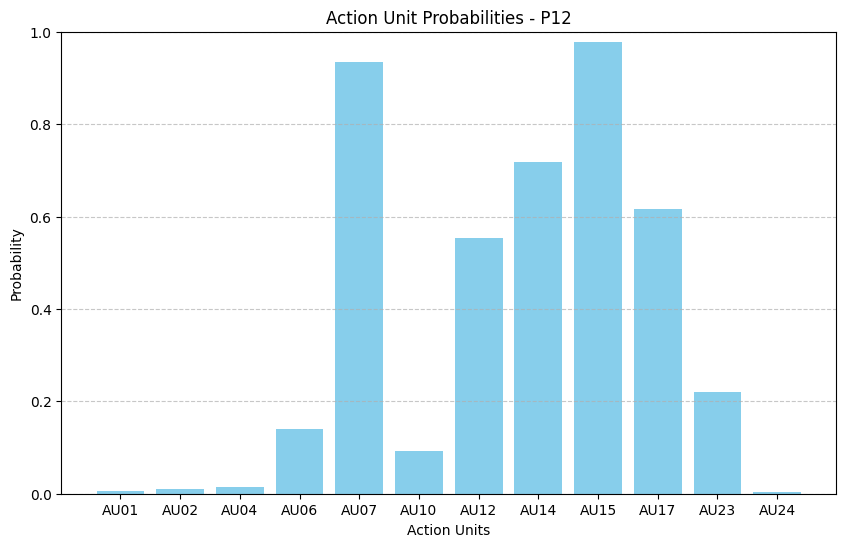

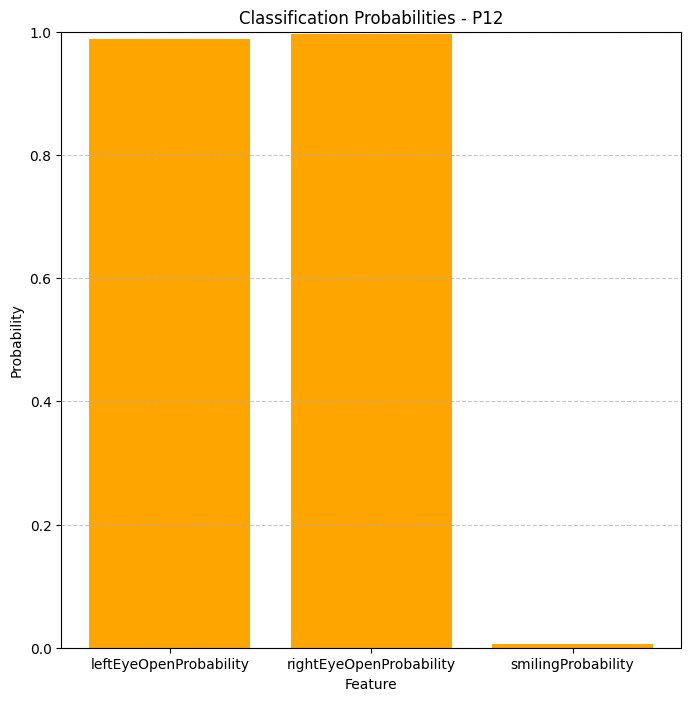

Bounding Box for P12: 231 1123 928 1821


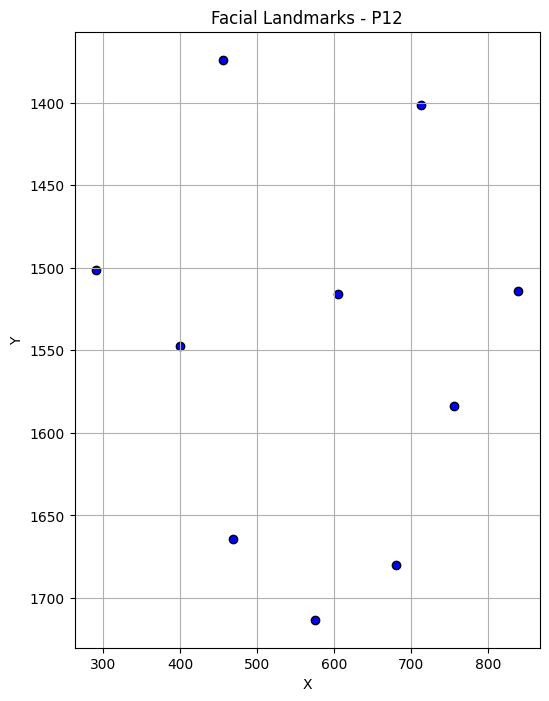

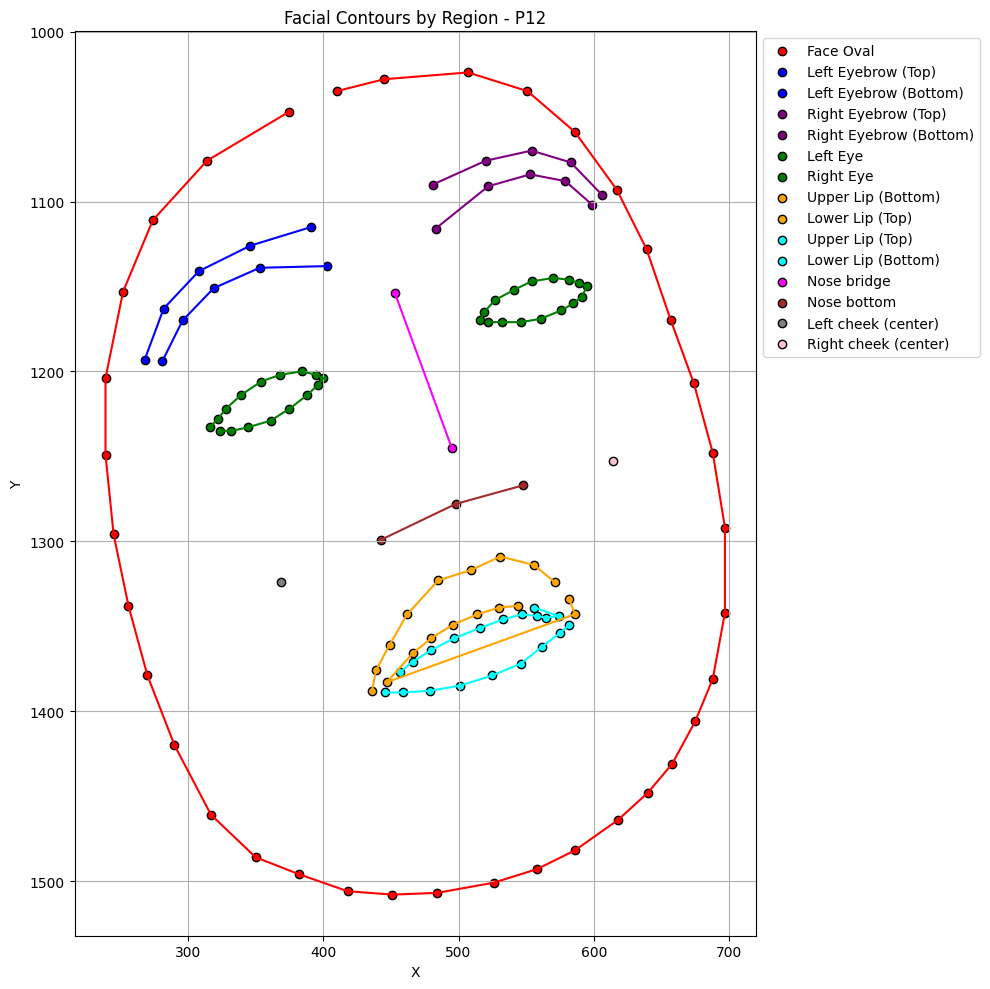

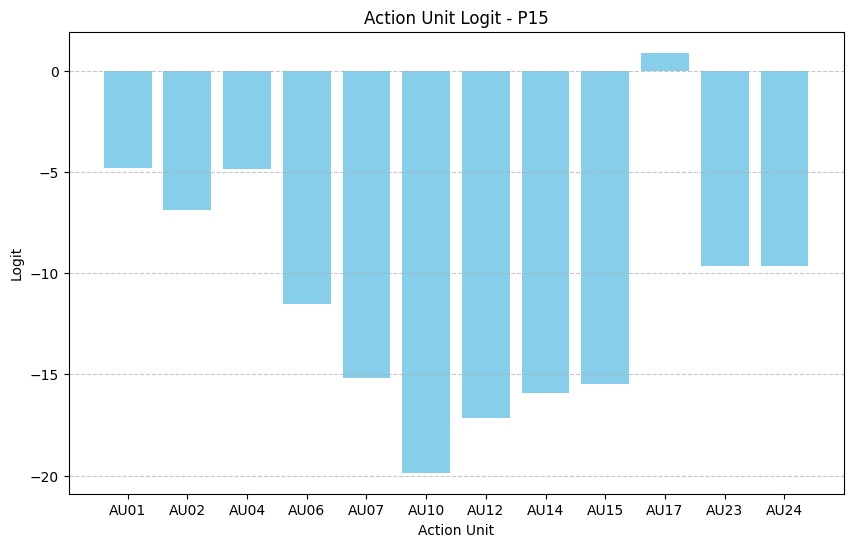

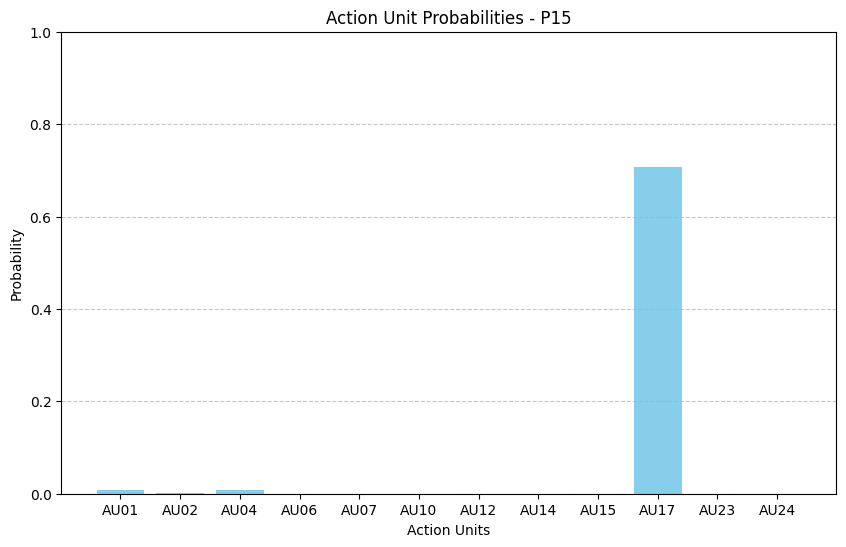

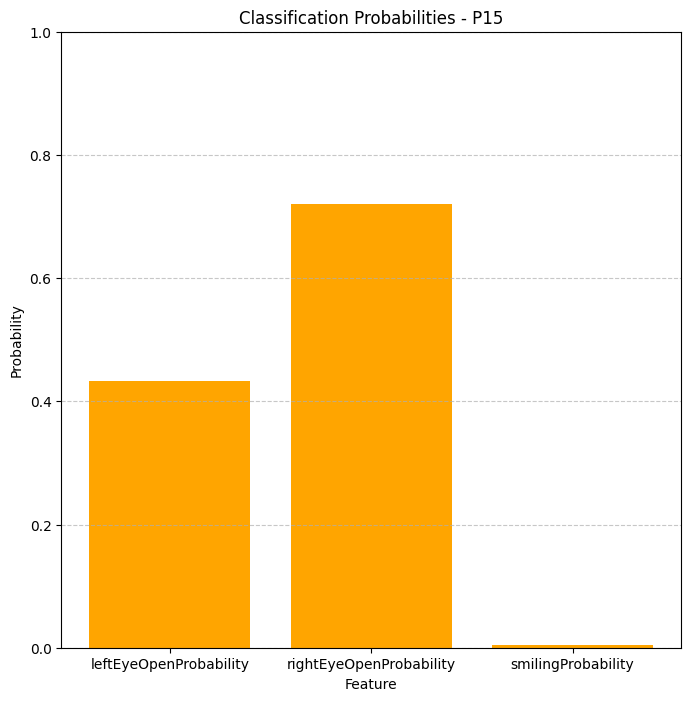

Bounding Box for P15: 122 832 1129 1839


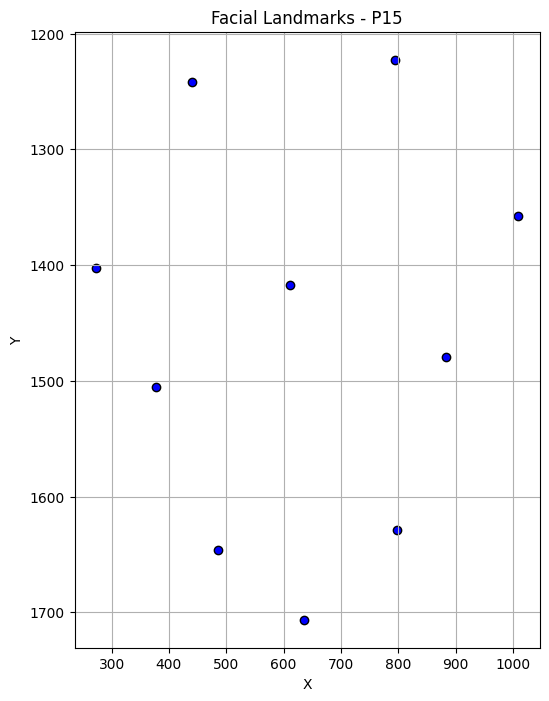

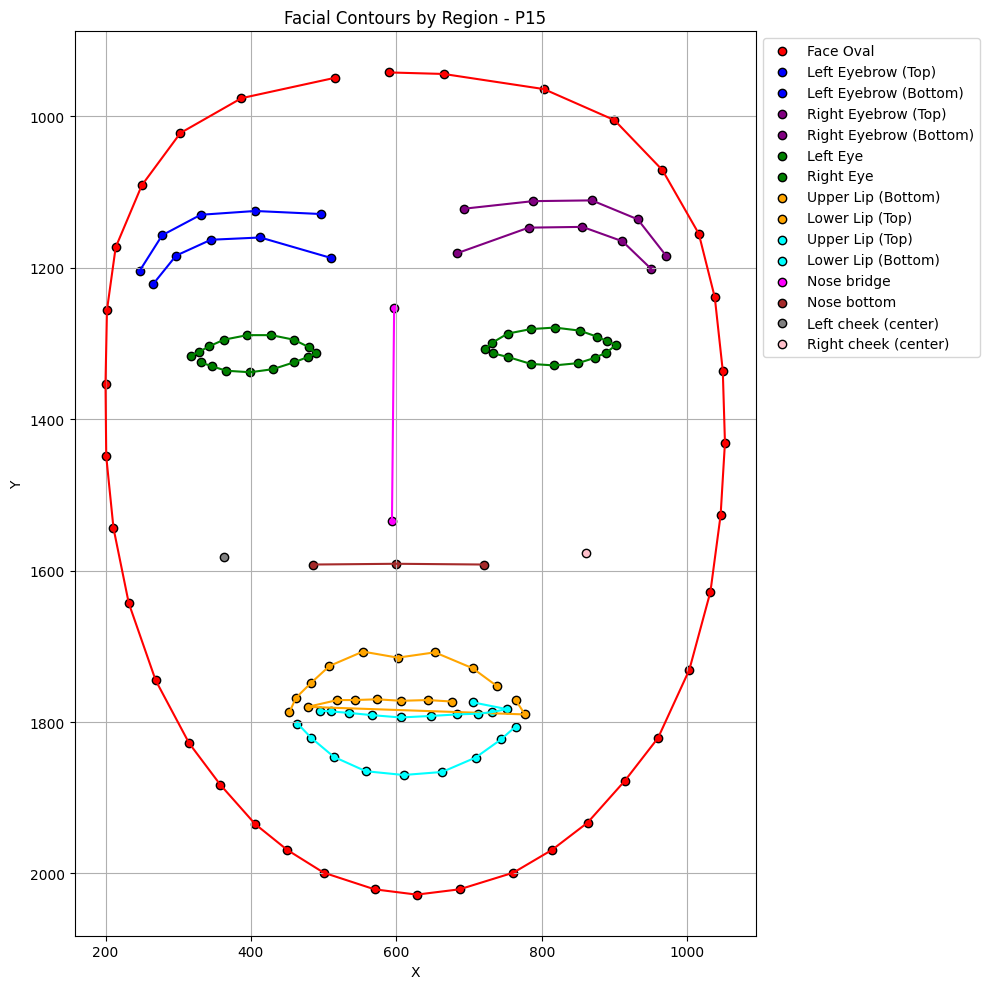

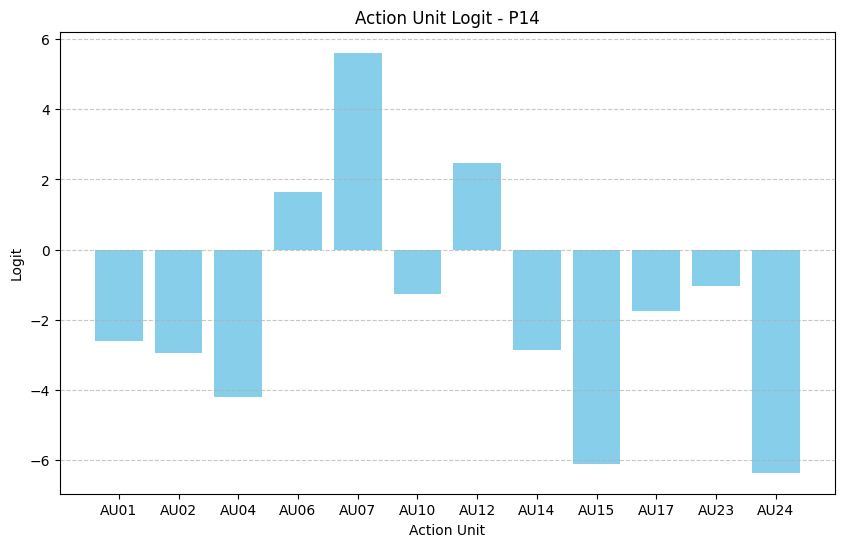

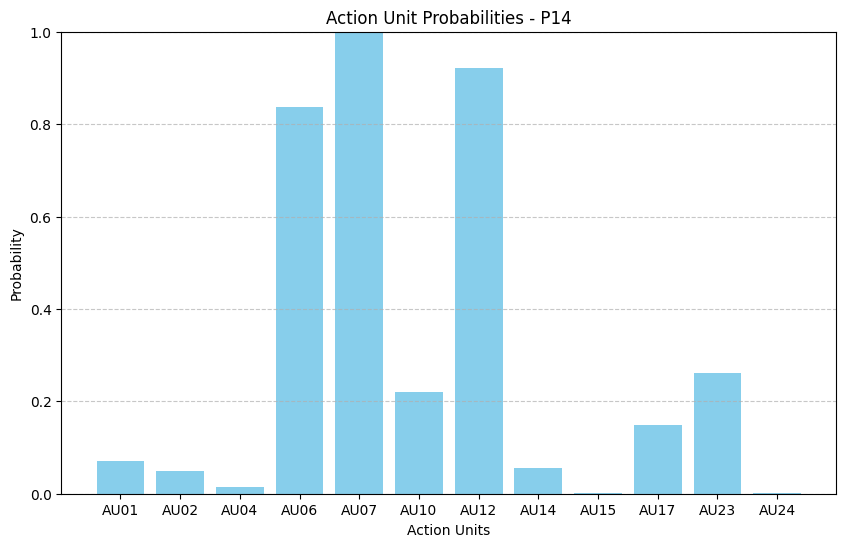

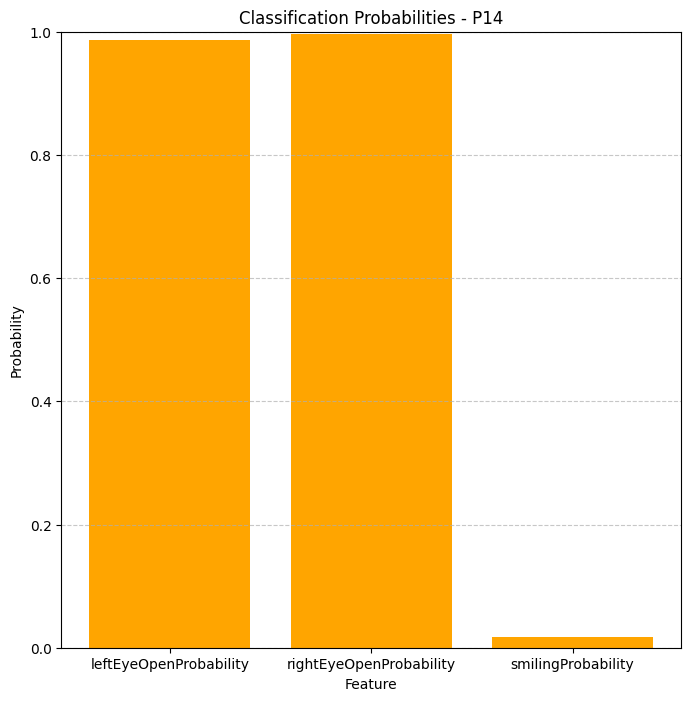

Bounding Box for P14: 35 922 942 1829


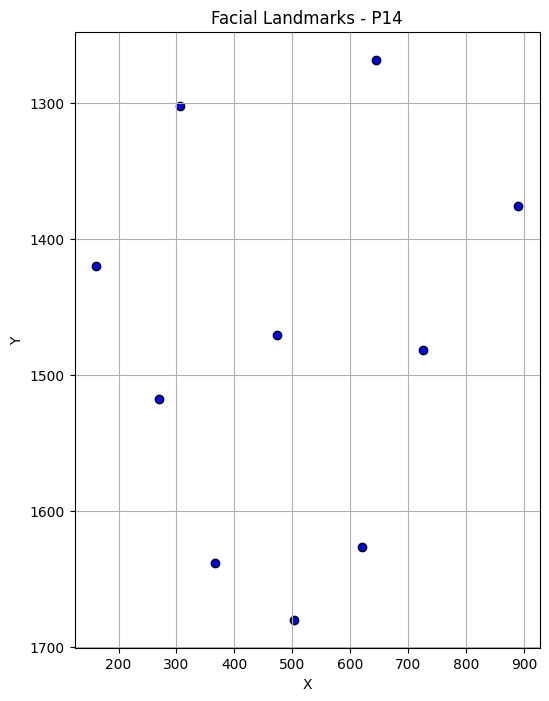

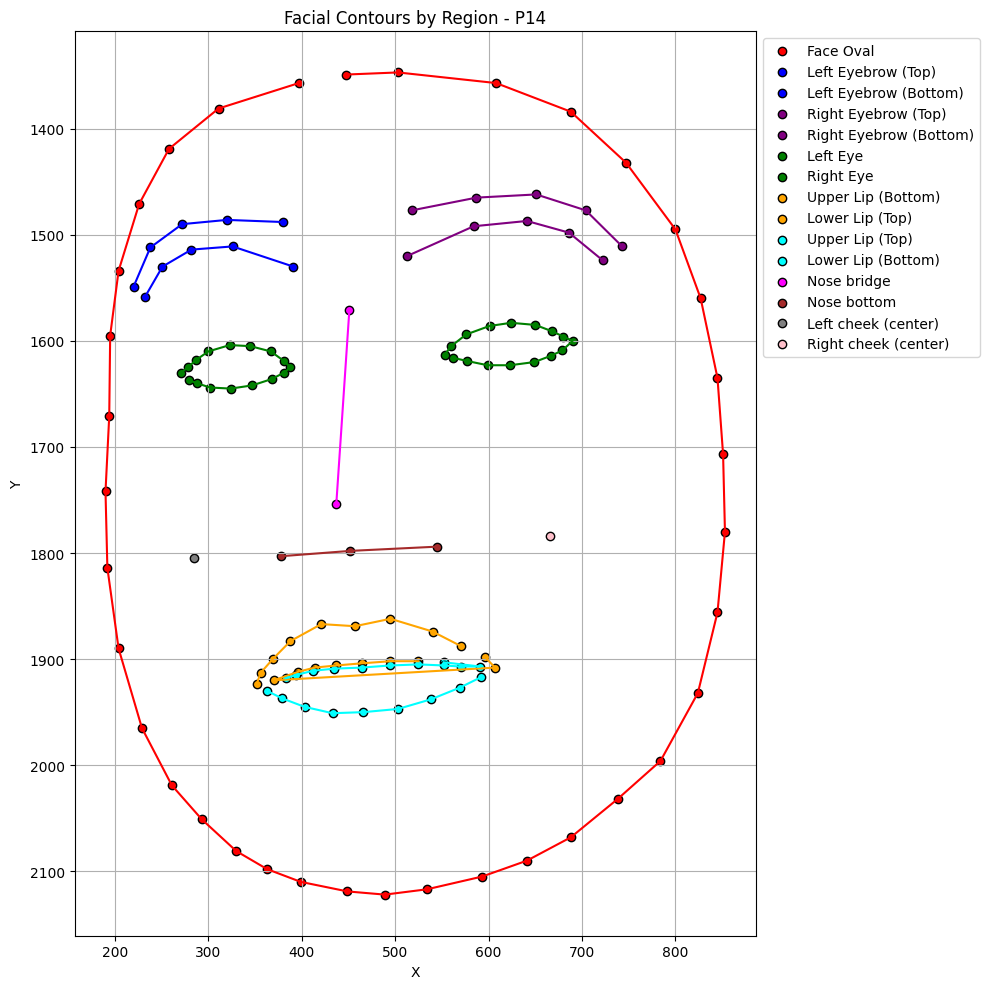

In [ ]:
# Step 2: Read and Process JSON Files (Loop through all files)
# ----------------------------------
json_files = [f for f in os.listdir(data_dir) if f.endswith(".json")]
feature_list = []

for json_file in json_files:
    file_path = os.path.join(data_dir, json_file)

    try:
        with open(file_path, "r") as f:
            data = json.load(f)

        participant_id = json_file.split(".")[0]

        # Create a dictionary to store features for this participant
        participant_features = {'pid': participant_id}

        # ----------------------------------
        # Action Units (AU)
        # ----------------------------------
        au_data = {}
        if isinstance(data, dict) and 'au' in data:
            au_data = data['au']
        elif isinstance(data, list):
            for item in data:
                if isinstance(item, dict) and 'au' in item:
                    au_data.update(item['au'])


        if au_data:
            au_names = list(au_data.keys())
            au_values = list(au_data.values())

            # Plot Logits
            plt.figure(figsize=(10, 6))
            plt.bar(au_names, au_values, color='skyblue')
            plt.title(f'Action Unit Logit - {participant_id}')
            plt.xlabel('Action Unit')
            plt.ylabel('Logit')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.show()

            # Convert logits to probabilities and plot
            au_probabilities = [1 / (1 + np.exp(-v)) for v in au_values]
            plt.figure(figsize=(10, 6))
            plt.bar(au_names, au_probabilities, color='skyblue')
            plt.title(f'Action Unit Probabilities - {participant_id}')
            plt.xlabel('Action Units')
            plt.ylabel('Probability')
            plt.ylim(0, 1)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.show()

        # ----------------------------------
        # Extracting and visualizing Classification probabilities
        # ----------------------------------
        classification = {}
        if isinstance(data, dict) and 'classification' in data:
            classification = data['classification']
        elif isinstance(data, list):
            for item in data:
                if isinstance(item, dict) and 'classification' in item:
                    classification.update(item['classification'])

        if classification:
            class_labels = list(classification.keys())
            class_values = list(classification.values())

            plt.figure(figsize=(8, 8))
            plt.bar(class_labels, class_values, color='orange')
            plt.title(f'Classification Probabilities - {participant_id}')
            plt.xlabel('Feature')
            plt.ylabel('Probability')
            plt.ylim(0, 1)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.show()

        # ----------------------------------
        # Extracting and visualizing Bounding Box
        # ----------------------------------
        bbox = None
        if isinstance(data, dict) and 'boundingBox' in data:
            bbox = data['boundingBox']
        elif isinstance(data, list):
            for item in data:
                if isinstance(item, dict) and 'boundingBox' in item:
                    bbox = item['boundingBox']

        if bbox:
            print(f"Bounding Box for {participant_id}:", bbox)

        # ----------------------------------
        # Extracting and visualizing Facial Landmarks
        # ----------------------------------
        landmarks = None
        if isinstance(data, dict) and 'landmarks' in data:
            landmarks = data['landmarks']
        elif isinstance(data, list):
            for item in data:
                if isinstance(item, dict) and 'landmarks' in item:
                    landmarks = item['landmarks']

        if landmarks:
            x_coords = [landmark['x'] for landmark in landmarks]
            y_coords = [landmark['y'] for landmark in landmarks]

            plt.figure(figsize=(6, 8))
            plt.scatter(x_coords, y_coords, c='blue', edgecolors='black')
            plt.gca().invert_yaxis()
            plt.title(f'Facial Landmarks - {participant_id}')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.grid(True)
            plt.show()

        # ----------------------------------
        # ----------------------------------
        # Extracting and visualizing Contours
        # ----------------------------------
        contours = {}

        if isinstance(data, dict) and 'contours' in data:
            contours = data['contours']
        elif isinstance(data, list):
            for item in data:
                if isinstance(item, dict) and 'contours' in item:
                    if isinstance(item['contours'], list):
                        for point in item['contours']:
                            if isinstance(point, dict) and 'x' in point and 'y' in point:
                                contours.setdefault('x', []).append(point['x'])
                                contours.setdefault('y', []).append(point['y'])

        if contours:
            x_contour = contours.get('x', [])
            y_contour = contours.get('y', [])

            # Define facial parts with indices and colors
            face_parts = [
                ((0, 35), 'Face Oval', 'red'),
                ((36, 40), 'Left Eyebrow (Top)', 'blue'),
                ((41, 45), 'Left Eyebrow (Bottom)', 'blue'),
                ((46, 50), 'Right Eyebrow (Top)', 'purple'),
                ((51, 55), 'Right Eyebrow (Bottom)', 'purple'),
                ((56, 71), 'Left Eye', 'green'),
                ((72, 87), 'Right Eye', 'green'),
                ((88, 96), 'Upper Lip (Bottom)', 'orange'),
                ((97, 105), 'Lower Lip (Top)', 'orange'),
                ((106, 116), 'Upper Lip (Top)', 'cyan'),
                ((117, 125), 'Lower Lip (Bottom)', 'cyan'),
                ((126,127), 'Nose bridge', 'magenta'),
                ((128,130), 'Nose bottom', 'brown'),
                ((131,131), 'Left cheek (center)', 'gray'),
                ((132,132), 'Right cheek (center)', 'pink')
            ]

            plt.figure(figsize=(10, 10))

            for (start, end), label, color in face_parts:
                if start < len(x_contour) and end < len(y_contour):  # Ensure valid indices
                    x_part = x_contour[start:end+1]
                    y_part = y_contour[start:end+1]
                    plt.scatter(x_part, y_part, label=label, c=color, edgecolors='black')
                    if end > start:
                        plt.plot(x_part, y_part, c=color)

            plt.gca().invert_yaxis()
            plt.title(f'Facial Contours by Region - {participant_id}')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.grid(True)
            plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
            plt.tight_layout()
            plt.show()
            # Append participant_features to the feature_list
        feature_list.append(participant_features)

    except Exception as e:
        print(f"Error processing {json_file}: {e}")

In [ ]:
# Load the PHQ-9 dataset again for merging
phq9_df = pd.read_csv(phq9_path)

In [ ]:
# Simulated extracted features (Replace this with actual feature extraction results)
extracted_features = pd.DataFrame({
    'pid': ['P08', 'P10', 'P12', 'P15', 'P18'],  # Sample participant IDs
    'AU01_mean': [0.5, 0.6, 0.4, 0.3, 0.7],
    'AU02_mean': [0.3, 0.5, 0.6, 0.2, 0.4],
    'eye_open_prob': [0.8, 0.7, 0.9, 0.6, 0.75],
    'smile_prob': [0.1, 0.2, 0.3, 0.15, 0.25],
    'head_pitch': [5.2, 3.1, 4.7, 6.0, 2.9],
    'head_yaw': [1.3, -0.5, 0.8, 1.5, -0.7],
    'head_roll': [-2.1, 1.2, -0.9, 0.5, 1.3]
})


In [ ]:

# Merge extracted features with PHQ-9 labels on 'pid'
merged_df = pd.merge(extracted_features, phq9_df, on='pid', how='inner')

In [ ]:
# Display merged dataset
# import ace_tools as tools  # Remove this line
# tools.display_dataframe_to_user(name="Merged Feature Dataset", dataframe=merged_df) # Remove this line

# Display the dataframe using pandas
print("Merged Feature Dataset:")
display(merged_df)

Merged Feature Dataset:


,pid,AU01_mean,AU02_mean,eye_open_prob,smile_prob,head_pitch,head_yaw,head_roll,start_ts,end_ts,start_phq9,end_phq9,depression_episode
0,P08,0.5,0.3,0.80,0.10,5.2,1.3,-2.1,7/21/22,8/9/22,6,1.0,0
1,P08,0.5,0.3,0.80,0.10,5.2,1.3,-2.1,8/9/22,8/23/22,1,9.0,0
2,P10,0.6,0.5,0.70,0.20,3.1,-0.5,1.2,7/21/22,8/9/22,8,7.0,1
3,P10,0.6,0.5,0.70,0.20,3.1,-0.5,1.2,8/9/22,9/2/22,7,2.0,0
4,P12,0.4,0.6,0.90,0.30,4.7,0.8,-0.9,7/22/22,8/9/22,10,12.0,1
5,P12,0.4,0.6,0.90,0.30,4.7,0.8,-0.9,8/9/22,8/23/22,12,9.0,1
6,P15,0.3,0.2,0.60,0.15,6.0,1.5,0.5,7/26/22,8/10/22,4,9.0,0
7,P15,0.3,0.2,0.60,0.15,6.0,1.5,0.5,8/10/22,8/23/22,9,5.0,1
8,P18,0.7,0.4,0.75,0.25,2.9,-0.7,1.3,7/27/22,8/9/22,15,19.0,1
9,P18,0.7,0.4,0.75,0.25,2.9,-0.7,1.3,8/9/22,8/23/22,19,15.0,1
